In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [3]:
# Deep Learning Denoising Pipeline Canvas (ULiteDenoiseDeblur)
"""
This canvas contains the classic deep learning denoising workflow, now using the
ULiteDenoiseDeblur U-Net–like architecture with dilated residual ConvBlocks.
1. Imports and configuration
2. ULiteDenoiseDeblur model definition
3. Transforms and PairedZipDataset loader
4. Training loop with MSE & SSIM, early stopping, checkpoints
5. DataLoaders & training invocation
6. Sync checkpoints to Drive
7. Test evaluation, histograms, and sample visualizations
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import zipfile, io
from pathlib import Path
from PIL import Image
import math
from pytorch_msssim import ssim
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import random


In [4]:
# ---------------------------------------------
# 1. ULiteDenoiseDeblur Definition
# ---------------------------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dilation=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=dilation, dilation=dilation),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=dilation, dilation=dilation),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1)
    def forward(self, x):
        return self.conv(x) + self.res_conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = ConvBlock(in_ch, out_ch)
    def forward(self, x):
        return self.block(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.block = ConvBlock(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        return self.block(torch.cat([x2, x1], dim=1))

class ULiteDenoiseDeblur(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_ch=32):
        super().__init__()
        self.inc   = ConvBlock(in_ch, base_ch)
        self.down1 = Down(base_ch, base_ch*2)
        self.down2 = Down(base_ch*2, base_ch*4)
        self.up1   = Up(base_ch*4, base_ch*2)
        self.up2   = Up(base_ch*2, base_ch)
        self.outc  = nn.Conv2d(base_ch, out_ch, 1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x  = self.up1(x3, x2)
        x  = self.up2(x, x1)
        return self.outc(x)



In [5]:
# ---------------------------------------------
# 2. Transforms & Loader
# ---------------------------------------------
mean, std = [0.1781], [0.1976]
target_size = (256,256)
train_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
val_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

class PairedZipDataset(torch.utils.data.Dataset):
    def __init__(self, clean_zip, noisy_zip, transform=None):
        self.clean_zip, self.noisy_zip = clean_zip, noisy_zip
        with zipfile.ZipFile(clean_zip, 'r') as zf:
            self.files = [Path(f).name for f in zf.namelist()
                          if f.startswith('clean/') and not f.endswith('/')]
        self.transform = transform or (lambda x: x)
        self.zc = None; self.zn = None
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        if self.zc is None: self.zc = zipfile.ZipFile(self.clean_zip)
        if self.zn is None: self.zn = zipfile.ZipFile(self.noisy_zip)
        fn = self.files[idx]
        clean = Image.open(io.BytesIO(self.zc.read(f'clean/{fn}'))).convert('L')
        noisy = Image.open(io.BytesIO(self.zn.read(f'noisy/{fn}'))).convert('L')
        return self.transform(noisy), self.transform(clean)




In [6]:
# ---------------------------------------------
# 3. Training Loop
# ---------------------------------------------
def train_model(model, train_loader, val_loader,
                epochs=50, lr=1e-3, patience=5,
                checkpoint_dir='checkpoints_ulite'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    os.makedirs(checkpoint_dir, exist_ok=True)
    best, waits = float('inf'), 0
    for e in range(1, epochs+1):
        print(f'Epoch {e}/{epochs}')
        model.train(); t_loss=t_ssim=0
        for X, Y in tqdm(train_loader, leave=False):
            X, Y = X.to(device), Y.to(device)
            P = model(X)
            loss = F.mse_loss(P, Y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            t_loss += loss.item()*X.size(0)
            t_ssim += ssim(P, Y, data_range=1.0, size_average=True).item()*X.size(0)
        t_loss /= len(train_loader.dataset); t_ssim /= len(train_loader.dataset)
        model.eval(); v_loss=v_ssim=v_psnr=0
        with torch.no_grad():
            for X, Y in tqdm(val_loader, leave=False):
                X, Y = X.to(device), Y.to(device)
                P = model(X)
                v_loss += F.mse_loss(P, Y).item()*X.size(0)
                v_ssim += ssim(P, Y, data_range=1.0, size_average=True).item()*X.size(0)
                m = ((P - Y)**2).mean().item()
                v_psnr += 10*math.log10(1.0/m)*X.size(0)
        v_loss /= len(val_loader.dataset); v_ssim /= len(val_loader.dataset); v_psnr /= len(val_loader.dataset)
        print(f'Train MSE={t_loss:.4f}, SSIM={t_ssim:.4f} | Val MSE={v_loss:.4f}, SSIM={v_ssim:.4f}, PSNR={v_psnr:.2f}dB')
        if v_loss < best:
            best, waits = v_loss, 0
            ckpt = os.path.join(checkpoint_dir, f'best_e{e}.pth')
            torch.save(model.state_dict(), ckpt)
            print(' Saved', ckpt)
        else:
            waits += 1
            print(f'No imp {waits}/{patience}')
            if waits >= patience:
                print('Early stopping')
                break


In [7]:
# ---------------------------------------------
# 4. DataLoaders & Training
# ---------------------------------------------
batch_size = 16
train_ds = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/train_clean.zip','/content/drive/MyDrive/IA2/dataset/train_noisy.zip', train_tf)
val_ds   = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/val_clean.zip','/content/drive/MyDrive/IA2/dataset/val_noisy.zip',     val_tf)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
model = ULiteDenoiseDeblur(in_ch=1, out_ch=1, base_ch=32)
train_model(model, train_loader, val_loader)


Epoch 1/50


Train MSE=0.1075, SSIM=0.5579 | Val MSE=0.0873, SSIM=0.5723, PSNR=10.88dB
 Saved checkpoints_ulite/best_e1.pth
Epoch 2/50


Train MSE=0.0784, SSIM=0.6150 | Val MSE=0.0826, SSIM=0.6042, PSNR=11.23dB
 Saved checkpoints_ulite/best_e2.pth
Epoch 3/50


Train MSE=0.0654, SSIM=0.6489 | Val MSE=0.0570, SSIM=0.6616, PSNR=12.69dB
 Saved checkpoints_ulite/best_e3.pth
Epoch 4/50


Train MSE=0.0548, SSIM=0.6773 | Val MSE=0.0483, SSIM=0.6986, PSNR=13.50dB
 Saved checkpoints_ulite/best_e4.pth
Epoch 5/50


Train MSE=0.0480, SSIM=0.6953 | Val MSE=0.0434, SSIM=0.7145, PSNR=14.03dB
 Saved checkpoints_ulite/best_e5.pth
Epoch 6/50


Train MSE=0.0436, SSIM=0.7069 | Val MSE=0.0391, SSIM=0.7061, PSNR=14.42dB
 Saved checkpoints_ulite/best_e6.pth
Epoch 7/50


Train MSE=0.0404, SSIM=0.7161 | Val MSE=0.0360, SSIM=0.7272, PSNR=14.83dB
 Saved checkpoints_ulite/best_e7.pth
Epoch 8/50


Train MSE=0.0371, SSIM=0.7252 | Val MSE=0.0320, SSIM=0.7376, PSNR=15.36dB
 Saved checkpoints_ulite/best_e8.pth
Epoch 9/50


Train MSE=0.0355, SSIM=0.7325 | Val MSE=0.0410, SSIM=0.7292, PSNR=14.33dB
No imp 1/5
Epoch 10/50


Train MSE=0.0338, SSIM=0.7372 | Val MSE=0.0352, SSIM=0.7339, PSNR=14.83dB
No imp 2/5
Epoch 11/50


Train MSE=0.0322, SSIM=0.7435 | Val MSE=0.0313, SSIM=0.7435, PSNR=15.43dB
 Saved checkpoints_ulite/best_e11.pth
Epoch 12/50


Train MSE=0.0311, SSIM=0.7466 | Val MSE=0.0320, SSIM=0.7401, PSNR=15.33dB
No imp 1/5
Epoch 13/50


Train MSE=0.0304, SSIM=0.7501 | Val MSE=0.0293, SSIM=0.7545, PSNR=15.75dB
 Saved checkpoints_ulite/best_e13.pth
Epoch 14/50


Train MSE=0.0301, SSIM=0.7503 | Val MSE=0.0272, SSIM=0.7633, PSNR=16.06dB
 Saved checkpoints_ulite/best_e14.pth
Epoch 15/50


Train MSE=0.0294, SSIM=0.7529 | Val MSE=0.0314, SSIM=0.7556, PSNR=15.39dB
No imp 1/5
Epoch 16/50


Train MSE=0.0287, SSIM=0.7556 | Val MSE=0.0284, SSIM=0.7574, PSNR=15.81dB
No imp 2/5
Epoch 17/50


Train MSE=0.0280, SSIM=0.7586 | Val MSE=0.0272, SSIM=0.7514, PSNR=16.06dB
 Saved checkpoints_ulite/best_e17.pth
Epoch 18/50


Train MSE=0.0278, SSIM=0.7597 | Val MSE=0.0300, SSIM=0.7570, PSNR=15.60dB
No imp 1/5
Epoch 19/50


Train MSE=0.0272, SSIM=0.7621 | Val MSE=0.0284, SSIM=0.7612, PSNR=15.88dB
No imp 2/5
Epoch 20/50


Train MSE=0.0269, SSIM=0.7615 | Val MSE=0.0258, SSIM=0.7658, PSNR=16.33dB
 Saved checkpoints_ulite/best_e20.pth
Epoch 21/50


Train MSE=0.0272, SSIM=0.7619 | Val MSE=0.0269, SSIM=0.7580, PSNR=16.10dB
No imp 1/5
Epoch 22/50


Train MSE=0.0258, SSIM=0.7668 | Val MSE=0.0255, SSIM=0.7650, PSNR=16.33dB
 Saved checkpoints_ulite/best_e22.pth
Epoch 23/50


Train MSE=0.0255, SSIM=0.7669 | Val MSE=0.0247, SSIM=0.7705, PSNR=16.51dB
 Saved checkpoints_ulite/best_e23.pth
Epoch 24/50


Train MSE=0.0255, SSIM=0.7669 | Val MSE=0.0252, SSIM=0.7695, PSNR=16.37dB
No imp 1/5
Epoch 25/50


Train MSE=0.0251, SSIM=0.7692 | Val MSE=0.0321, SSIM=0.7500, PSNR=15.40dB
No imp 2/5
Epoch 26/50


Train MSE=0.0249, SSIM=0.7699 | Val MSE=0.0249, SSIM=0.7721, PSNR=16.47dB
No imp 3/5
Epoch 27/50


Train MSE=0.0247, SSIM=0.7696 | Val MSE=0.0253, SSIM=0.7675, PSNR=16.37dB
No imp 4/5
Epoch 28/50


Train MSE=0.0249, SSIM=0.7683 | Val MSE=0.0274, SSIM=0.7547, PSNR=16.00dB
No imp 5/5
Early stopping


In [8]:
# ---------------------------------------------
# 5. Sync Checkpoints to Drive
# ---------------------------------------------
import shutil
shutil.copytree('checkpoints_ulite', '/content/drive/MyDrive/IA2/ulite_checkpoints', dirs_exist_ok=True)
print('Checkpoints synced')


Checkpoints synced


Testing: 100%|██████████| 125/125 [00:21<00:00,  5.78it/s]


Test MSE: 0.0010
Test SSIM: 0.8203
Test PSNR: 31.91 dB


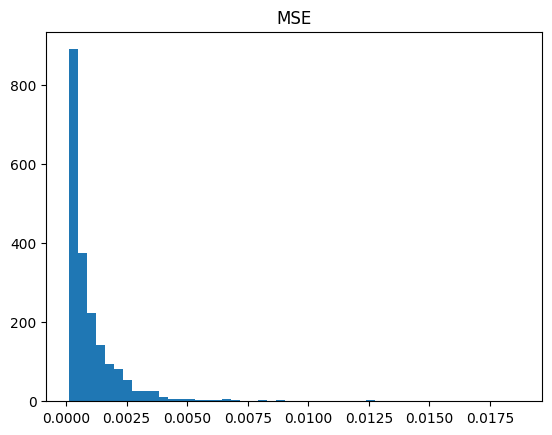

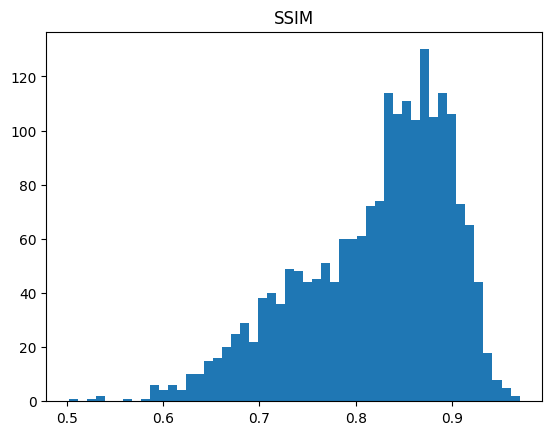

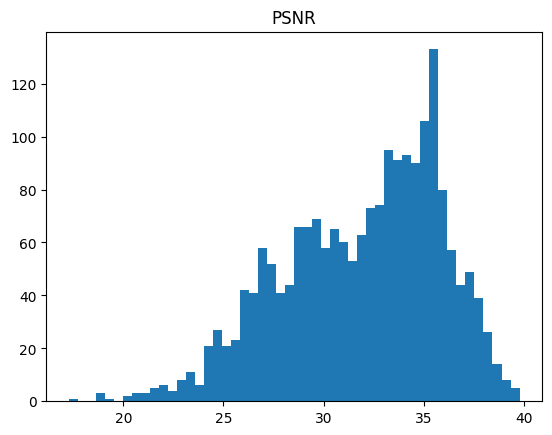

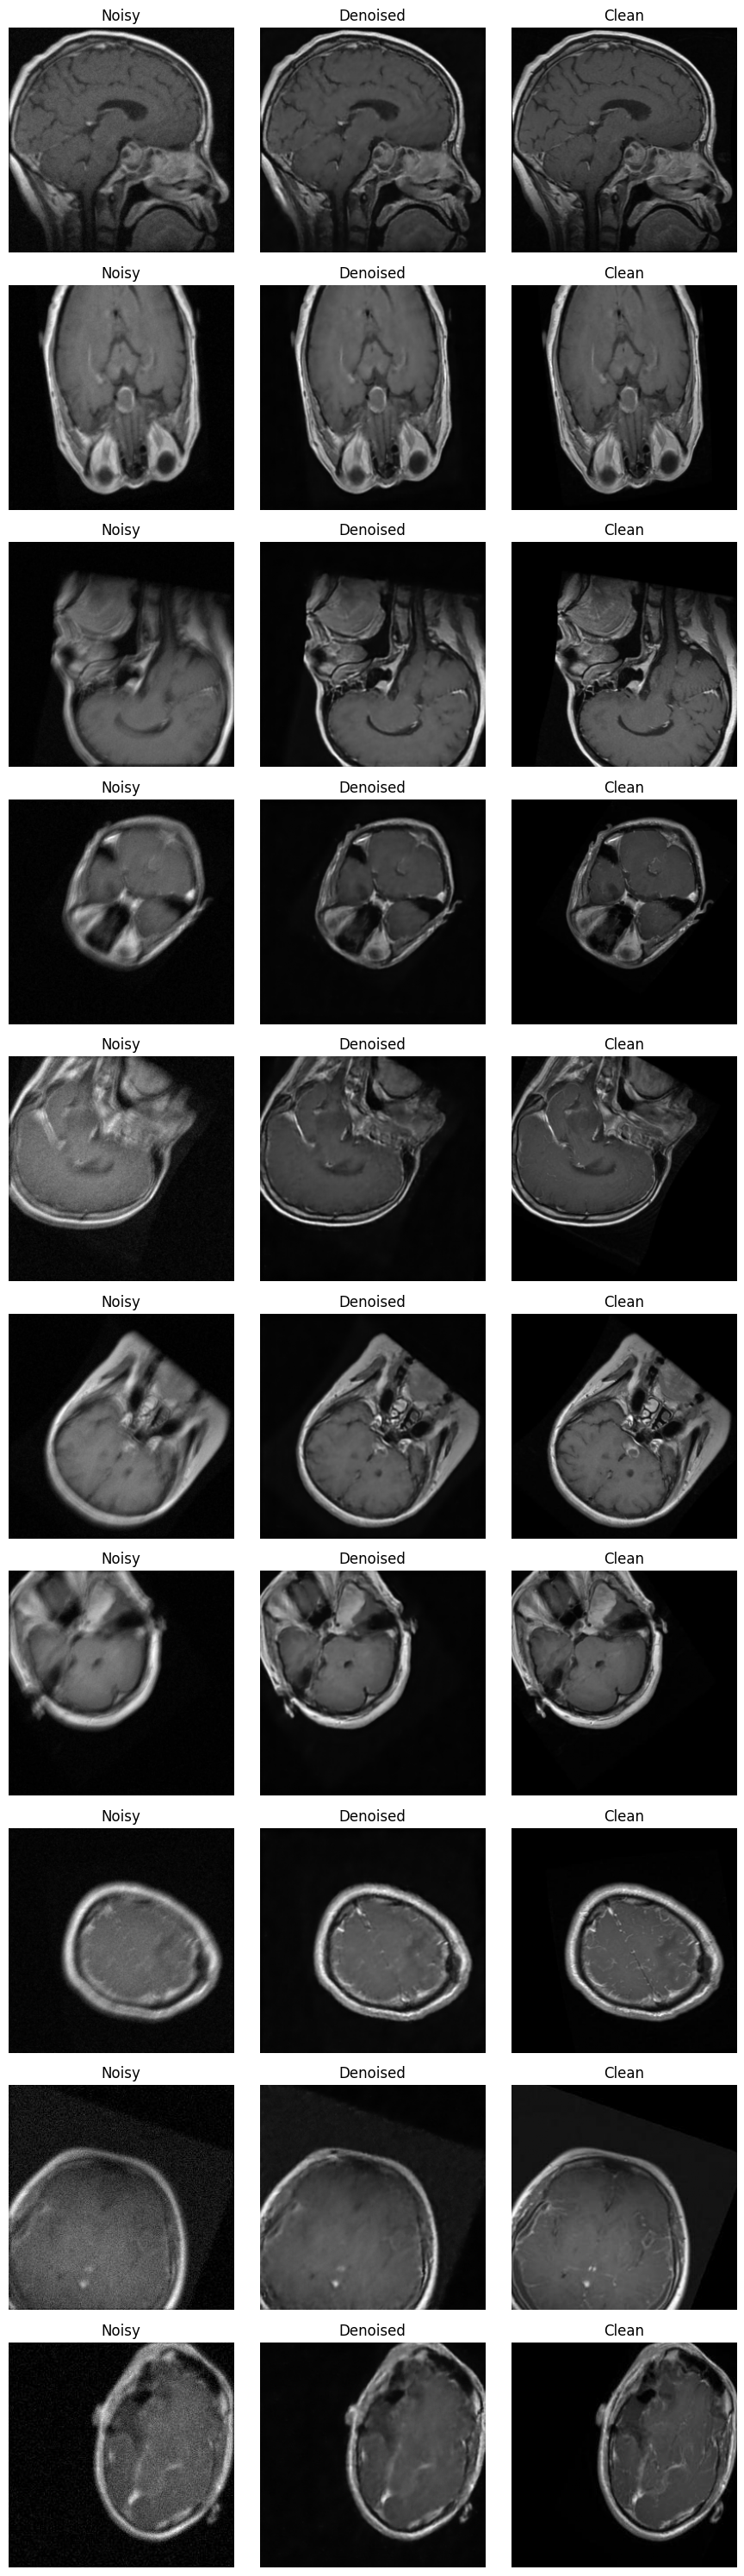

In [11]:
# ---------------------------------------------
# 6. Test Evaluation & Visualization
#---------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval(); model.to(device)
test_ds = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/test_clean.zip','/content/drive/MyDrive/IA2/dataset/test_noisy.zip', val_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

m_list, s_list, p_list = [], [], []
with torch.no_grad():
    for n, c in tqdm(test_loader, desc='Testing'):
        n, c = n.to(device), c.to(device)
        d = model(n)
        pd, cd = d * std[0] + mean[0], c * std[0] + mean[0]
        for i in range(pd.size(0)):
            mse_i = ((pd[i] - cd[i])**2).mean().item(); m_list.append(mse_i)
            s_list.append(ssim(pd[i].unsqueeze(0), cd[i].unsqueeze(0), data_range=1.0, size_average=True).item())
            p_list.append(10 * math.log10(1.0 / mse_i))
# Compute and print average metrics
avg_mse = sum(m_list) / len(m_list)
avg_ssim = sum(s_list) / len(s_list)
avg_psnr = sum(p_list) / len(p_list)
print(f"Test MSE: {avg_mse:.4f}")
print(f"Test SSIM: {avg_ssim:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")
# Histograms
plt.figure(); plt.hist(m_list, bins=50); plt.title('MSE'); plt.show()
plt.figure(); plt.hist(s_list, bins=50); plt.title('SSIM'); plt.show()
plt.figure(); plt.hist(p_list, bins=50); plt.title('PSNR'); plt.show()
# Sample Visualizations
indices = random.sample(range(len(test_ds)), 10)
fig, ax = plt.subplots(10, 3, figsize=(9, 30))
for i, idx in enumerate(indices):
    n, c = test_ds[idx]
    d = model(n.unsqueeze(0).to(device)).squeeze(0).cpu()
    def den(t): return (t * std[0] + mean[0]).detach().numpy().squeeze()
    ax[i,0].imshow(den(n),   cmap='gray'); ax[i,0].axis('off'); ax[i,0].set_title('Noisy')
    ax[i,1].imshow(den(d),   cmap='gray'); ax[i,1].axis('off'); ax[i,1].set_title('Denoised')
    ax[i,2].imshow(den(c),   cmap='gray'); ax[i,2].axis('off'); ax[i,2].set_title('Clean')
plt.tight_layout(); plt.show()